# 1. Import library

In [48]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as A

# 2. Load data

In [49]:
# 기학습 모델 사용하여 test image의 capitate infernce data load
df=pd.read_csv('code/output_unet++_diceiou.csv')

In [50]:
# Capitate 분리
df_capitate = df[df['class']=='Capitate']
df_capitate

,image_name,class,rle
21,image1661319116107.png,Capitate,2954193 3 2956237 12 2958282 19 2960328 23 296...
50,image1661319145363.png,Capitate,2806762 5 2808808 12 2810853 19 2812895 26 281...
79,image1661319356239.png,Capitate,2741231 8 2743277 12 2745321 19 2747363 28 274...
108,image1661319390106.png,Capitate,2714523 22 2716570 26 2718616 31 2720661 40 27...
137,image1661320372752.png,Capitate,2767876 4 2769902 30 2771939 43 2773982 50 277...
...,...,...,...
8228,image1664154624841.png,Capitate,2452479 13 2454524 18 2456566 33 2458599 51 24...
8257,image1667354218823.png,Capitate,2790428 10 2790440 12 2792472 33 2794515 41 27...
8286,image1667354234602.png,Capitate,2759653 3 2761694 25 2763739 34 2765786 44 276...
8315,image1667354405140.png,Capitate,2687982 2 2690013 13 2690027 8 2692024 5 26920...


# 3. Decode RLE & Get coordinate

In [51]:
# Decode rle to mask
def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [116]:
def capitate_mask_coor(dataframe, imageidx, height, width):
    capitate_mask = decode_rle_to_mask(dataframe.iloc[imageidx]['rle'], height, width)
    file_name = dataframe.iloc[imageidx]['image_name']
    y_coor, x_coor = np.where(capitate_mask == 1)
    x_mean, y_mean = int(np.mean(x_coor)), int(np.mean(y_coor))
    
    return file_name, (x_mean, y_mean)

'''
imageidx: sample을 확인할 image index
width, height = 확인용 원본 image size
'''
imageidx = 209
width, height = 2048, 2048
filename, coor = capitate_mask_coor(df_capitate, imageidx, height, width)

print(f'File name: {filename}')
print(f'Coor: {coor}')

File name: image1663636433659.png
Coor: (1067, 1310)


# 4. Check

In [117]:
# Test image root
test_image_root = 'data/test/DCM'

In [118]:
# Test image ID/filename 저장
sample_path = '/data/ephemeral/home/level2-cv-semanticsegmentation-cv-03-lv3/data/test/DCM/ID040/image1661319116107.png'
sample_path = 'image1661319116107.png'

pngs = [
    os.path.relpath(os.path.join(root, fname), start=test_image_root)
    for root, dirs, files in os.walk(test_image_root)
    for fname in files
    if os.path.splitext(fname)[1].lower() == '.png'
]

pngs = sorted(pngs)

In [119]:
# Make crop_coor
def crop_coordinate(coordinate):
    x, y = coordinate
    x_min = x - 256
    y_min = y - 256
    x_max = x + 256
    y_max = y + 256
    
    return x_min, y_min, x_max, y_max

rectangle_x, rectangle_y = crop_coordinate(coor)[0], crop_coordinate(coor)[1]

print(rectangle_x, rectangle_y)

811 1054


In [120]:
if filename == pngs[imageidx].split('/')[1]:
    print('Coordinate is matched image_file')
else:
    print('Check the middle_coordinate and image_file')

# crop size & load image
crop_width, crop_height = 512, 512
image = cv2.imread(os.path.join(test_image_root, pngs[imageidx]))

Coordinate is matched image_file


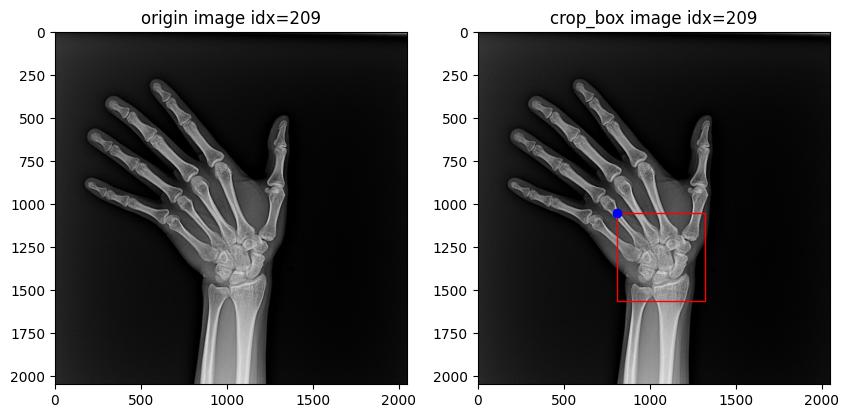

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
rectangle = patches.Rectangle((rectangle_x, rectangle_y), width=crop_width, height=crop_height, linewidth=1, edgecolor='red', facecolor='none')

ax[0].imshow(image)
# ax[0].axis('off')
ax[0].set_title(f'origin image idx={imageidx}')

ax[1].imshow(image)
# ax[1].axis('off')
ax[1].set_title(f'crop_box image idx={imageidx}')
ax[1].add_patch(rectangle)
# rectangle  좌표 확인
ax[1].scatter(rectangle_x, rectangle_y, color='blue')

plt.show()

# 5. Make all crop_coordinate

In [66]:
crop_data = []

def make_crop_coor(dataframe, imageidx, height, width):
    filename, coor = capitate_mask_coor(dataframe=dataframe, 
                                        imageidx=imageidx, 
                                        height=height, 
                                        width=width)
    x_min, y_min, x_max, y_max = crop_coordinate(coor)

    return filename, x_min, y_min, x_max, y_max

height, width = 2048, 2048

for idx in range(len(df_capitate)):
    filename, x_min, y_min, x_max, y_max = make_crop_coor(df_capitate, idx, height, width)

    crop_data.append([filename, x_min, y_min, x_max, y_max])

df_crop = pd.DataFrame(crop_data, columns=['filename', 'x_min', 'y_min', 'x_max', 'y_max'])

df_crop
    

,filename,x_min,y_min,x_max,y_max
0,image1661319116107.png,697,1273,1209,1785
1,image1661319145363.png,770,1203,1282,1715
2,image1661319356239.png,726,1167,1238,1679
3,image1661319390106.png,703,1151,1215,1663
4,image1661320372752.png,737,1164,1249,1676
...,...,...,...,...,...
283,image1664154624841.png,785,1004,1297,1516
284,image1667354218823.png,776,1189,1288,1701
285,image1667354234602.png,792,1176,1304,1688
286,image1667354405140.png,707,1146,1219,1658


In [67]:
df_crop.to_csv('손목모델_crop_coor.csv', index=False)

# 6. Make crop images

In [137]:
df_coordinate = pd.read_csv('손목모델_crop_coor.csv')
df_coordinate

,filename,x_min,y_min,x_max,y_max
0,image1661319116107.png,697,1273,1209,1785
1,image1661319145363.png,770,1203,1282,1715
2,image1661319356239.png,726,1167,1238,1679
3,image1661319390106.png,703,1151,1215,1663
4,image1661320372752.png,737,1164,1249,1676
...,...,...,...,...,...
283,image1664154624841.png,785,1004,1297,1516
284,image1667354218823.png,776,1189,1288,1701
285,image1667354234602.png,792,1176,1304,1688
286,image1667354405140.png,707,1146,1219,1658


In [146]:
os.path.split(pngs[0])[0]

'ID040'

In [ ]:
save_dir = 'Crop_test_data/test/DCM'

for _idx, file_root in enumerate(pngs):
    os.makedirs(save_dir, exist_ok=True)
    
    image_root = os.path.join(test_image_root, file_root)
    image = cv2.imread(image_root)

    image_coor = df_coordinate[df_coordinate['filename'] == os.path.basename(image_root)]
    x_min, y_min, x_max, y_max = image_coor['x_min'], image_coor['y_min'], image_coor['x_max'], image_coor['y_max']

    tf = A.Compose([A.Crop(x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max, always_apply=True)])
    crop_image = tf(image=image)['image']

    os.makedirs(os.path.join(save_dir, os.path.split(file_root)[0]), exist_ok=True)
    cv2.imwrite(os.path.join(save_dir, file_root), crop_image)


In [152]:
crop_pngs = [
    os.path.relpath(os.path.join(root, fname), start=save_dir)
    for root, dirs, files in os.walk(save_dir)
    for fname in files
    if os.path.splitext(fname)[1] == 'pngs'
]

crop_pngs = sorted(pngs)
len(crop_pngs)

288